# Exploring Latent Spaces: A Comparative Analysis

**Authors:**
- Marco Bernardi (ID: 2107781)
- Davide Baggio (ID: 2119982)

**Course:** 
- Machine Learning

**GitHub Repository:**
- [Project Repository](https://github.com/marco-bernardi/BigBiGAN-PyTorch)

**How to run the Notebook:** \
To execute this notebook, place it in the root folder of the repository. \
The trained model is located at the following path: `data/FMNIST/bigbigan/checkpoints/checkpoint_40.pth`.





# Visualizing latent space with dimensionality reduction

In this notebook, we aim to gain insights into the latent space of a BigBiGAN (Big Generative Adversarial Network) Encoder using dimensionality reduction techniques such as Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE). 

Dimensionality reduction is the transformation of data from a high-dimensional space into a low-dimensional one which retains some meaningful properties of the original data, ideally close to its intrinsic dimension. The reason behind this technique is that in high-dimensional spaces we often incur in the "curse of dimensionality" which says that as the number of features or dimensions in a dataset increases, the amount of data required to generalize accurately grows exponentially. It can lead to increased computational complexity, overfitting, and difficulties in visualizing and interpreting the data. Also, high-dimensional datasets contain more noise or irrelevant features that do not contribute significantly to the underlying structure of the data, so reducing the dimensionality helps to filter that noise, emphasizing the most important information and improving the overall performance of models.

The primary goal of this project is to visualize the latent representations of a dataset and identify instances of ambiguous or incorrectly reconstructed images based on a given class.

## Background

[BigBiGAN](https://arxiv.org/abs/1907.02544) is a powerful generative model that learns a joint distribution of images and their corresponding latent codes. The latent space encodes meaningful features of the data, allowing for effective generation and reconstruction, however understanding the structure of this latent space can be challenging, especially when dealing with ambiguous or misclassified data.

## Objectives

1. Utilize PCA and t-SNE to reduce the dimensionality of the BigBiGAN latent space.
2. Visualize the distribution of latent codes in a lower-dimensional space.
3. Identify instances of incorrect reconstruction or ambiguity within the latent representations.

## Dataset

For the anlysis we will be using the [Fashion MNIST (F-MNIST)](https://arxiv.org/abs/1708.07747) dataset, which is composed by 70.000 28x28 images of fashion products and represents a valid and more challenging alternative to the more popular MNIST dataset.

In order to run this notebook please ensure that you have the F-MNIST dataset and a trained BigBiGAN model for experimentation. The notebook will guide you through the process of applying dimensionality reduction.


In [13]:
import itertools
from src.pipeline import pipeline
from src.training_utils import training_utils


import torch
from torchvision import transforms
from torch.utils import data as tdataset
from torchvision.datasets import FashionMNIST
from torch.utils.data import Subset


from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Configuration of parameters for trained models

In the process of configuring parameters to align with the trained models, a specific choice is made regarding the architecture of BigBiGAN. \
The selected architecture employs a latent dimensionality of 4. Furthermore, the model incorporates a RevNet Encoder for its encoding operations.

This configuration is pivotal as it establishes the foundational parameters for subsequent operations and analyses. 
The latent dimension of 4 is a deliberate choice, offering a balance between expressive power and computational efficiency. 
Additionally, the integration of a RevNet Encoder signifies the use of a reversible neural network structure for encoding, contributing to the model's capacity to learn intricate representations.

Careful consideration of these parameters ensures that the subsequent model operations are aligned with the intended architecture, allowing for meaningful and effective utilization of the trained BigBiGAN model.

## Model Training:

The model underwent training for a total of 40 epochs. The decision to conclude training at this epoch was based on the following criteria:
- **Image Quality:** The image quality achieved at the 40th epoch was deemed acceptable.
- **Loss Function Stability:** The loss function demonstrated stability, contributing to the decision to stop training.

#### Hardware Specifications:
- GPU: NVIDIA RTX 3060
- CPU: Intel Core i7-10700
- RAM: 16GB DDR4



In [3]:
EXP_HPARAMS = {
    "params": (
        {},
    ),
    "seeds": (420,),
}
config = training_utils.get_config("FMNIST")
for hparams_overwrite_list, seed in itertools.product(EXP_HPARAMS["params"], EXP_HPARAMS["seeds"]):
    hparams_str = ""
    for k, v in hparams_overwrite_list.items():
        config[k] = v
        hparams_str += str(k) + "-" + str(v) + "_"
    config["model_architecture"] = "bigbigan"
    config["hparams_str"] = hparams_str.strip("_")
    config["seed"] = seed
    config["bs"] = 1
    config["latent_dim"] = 4

In [4]:
pip = pipeline.BigBiGANInference.from_checkpoint(checkpoint_path="./data/FMNIST/bigbigan/checkpoints/checkpoint_40.pth", data_path="./data", config=config)

### LOAD F-MNIST DATASET

Choose if use the full F-Mnist Dataset or only a subset of it.
For use the full dataset replace the following line
```final_dataset = subset_FMNIST```

with:

```final_dataset = dataset_FMNIST```

Otherwise if you are ok with using only a subset doesn't edit the ```final_dataset``` and edit the ```subset_indices``` according to your preference.
With a range of 10000 you'll have more or less 80 images for class.

[WARNING]

On google colab the use of the full dataset will result in a long execution time.
The fit of the TSNE model could take up to an hour using the full dataset.




In [41]:
use_full_dataset = False
range_ = 10000

dataset_FMNIST = FashionMNIST(
        "./data",
        download=True,
        transform=transforms.Compose([
            transforms.Resize(config.image_size),
            transforms.CenterCrop(config.image_size),
            transforms.ToTensor(),
        ])
)
# Define the indices for the subset (e.g., first 10,000 samples)
subset_indices = range(range_)  # Adjust the range based on your subset size
subset_FMNIST = Subset(dataset_FMNIST, subset_indices)

if use_full_dataset:
    final_dataset = dataset_FMNIST
else:
    final_dataset = subset_FMNIST



loader = tdataset.DataLoader(
        subset_FMNIST,
        batch_size=1,
        shuffle=True,
        drop_last=True,
)

def get_dataloader(dataset, batch_size=1, class_label=[0]):
    filtered_indices = [i for i, (_, label) in enumerate(dataset) if label in class_label]
    filtered_dataset = torch.utils.data.Subset(dataset, filtered_indices)
    dataloader = torch.utils.data.DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)
    print(f"Number of images in dataloader: {len(dataloader)}")
    return dataloader

### Create a different dataloader for each class of images

In [42]:
zero_dl  = get_dataloader(final_dataset, batch_size=12, class_label=[0])
one_dl   = get_dataloader(final_dataset, batch_size=12, class_label=[1])
two_dl   = get_dataloader(final_dataset, batch_size=12, class_label=[2])
three_dl = get_dataloader(final_dataset, batch_size=12, class_label=[3])
four_dl  = get_dataloader(final_dataset, batch_size=12, class_label=[4])
five_dl  = get_dataloader(final_dataset, batch_size=12, class_label=[5])
six_dl   = get_dataloader(final_dataset, batch_size=12, class_label=[6])
seven_dl = get_dataloader(final_dataset, batch_size=12, class_label=[7])
eight_dl = get_dataloader(final_dataset, batch_size=12, class_label=[8])
nine_dl  = get_dataloader(final_dataset, batch_size=12, class_label=[9])

Number of images in dataloader: 79
Number of images in dataloader: 86
Number of images in dataloader: 85
Number of images in dataloader: 85
Number of images in dataloader: 82
Number of images in dataloader: 83
Number of images in dataloader: 86
Number of images in dataloader: 86
Number of images in dataloader: 83
Number of images in dataloader: 84


0it [00:00, ?it/s]

Latent shape:  torch.Size([12, 4])


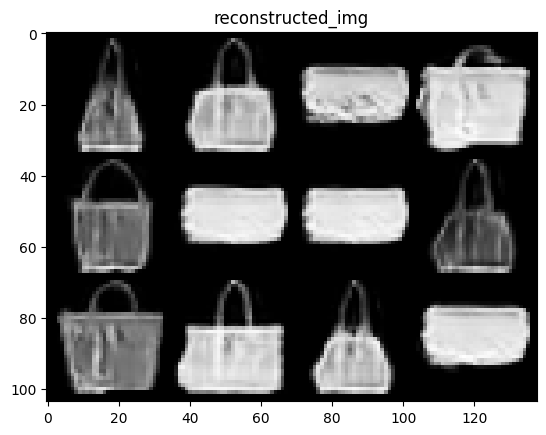

In [28]:
#Model testing
pip.inference_fromdt(eight_dl)

In [29]:
#Function to print labels of a dataset
def print_labels(dataset):
    labels = []
    for _, label in dataset:
        labels.append(label)
    print(set(labels))

#Function to encode a batch of images
def encode_batch(pip, dataloader):
    print("Dataloader size: ", len(dataloader))
    encoded_images = []
    for batch_images, batch_labels in dataloader:
        #batch_images = batch_images.unsqueeze(0)
        batch_images = batch_images.to(config.device)
        z_img = pip.encode(batch_images)
        encoded_images.append(z_img.detach().cpu().numpy())
    #encoded_images = np.array(encoded_images)
    encoded_images = np.concatenate(encoded_images, axis=0)

    return encoded_images

In [30]:
#Encoding the images
z_one   = encode_batch(pip, zero_dl)
z_two   = encode_batch(pip, two_dl)
z_three = encode_batch(pip, three_dl)
z_four  = encode_batch(pip, four_dl)
z_five  = encode_batch(pip, five_dl)
z_six   = encode_batch(pip, six_dl)
z_seven = encode_batch(pip, seven_dl)
z_eight = encode_batch(pip, eight_dl)
z_nine  = encode_batch(pip, nine_dl)
z_zero  = encode_batch(pip, zero_dl)

Dataloader size:  79
Dataloader size:  85
Dataloader size:  85
Dataloader size:  82
Dataloader size:  83
Dataloader size:  86
Dataloader size:  86
Dataloader size:  83
Dataloader size:  84
Dataloader size:  79


# Techniques for dimensionality reduction: PCA vs t-SNE

The difference between PCA and t-SNE is mainly the approach that these methods use to perform the dimensionality reduction. It's important to note that all dimensionality reduction techniques fall under the category of unsupervised machine learning, revealing hidden patterns and important relationships in the data without requiring labels.

## [PCA](https://arxiv.org/pdf/1404.1100.pdf) (Principal Component Analysis)

PCA is a linear technique that focuses on finding the principal components, as the name suggests, to capture the most variance in the global data. This means that local relationships (like clusters) may be lost after the projection. PCA is deterministic, meaning the same input data will always produce the same output (the principal components).

## [t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) (t-Distributed Stochastic Neighbor Embedding)

t-SNE is a non-linear technique that focuses on preserving pairwise similarities between data points on global and local structures. The clusters generated are well distinguishable from each other. However, it's important to note that distances in the low-dimensional space are not indicative of cluster separations in the high-dimensional one. t-SNE is stochastic, and its outputs will be different due to the use of probability distributions over pairs of high-dimensional data points in both spaces.

## Considerations

The deterministic nature of PCA can be advantageous in scenarios where stability and consistent interpretations of results are crucial. Researchers and practitioners can rely on PCA to consistently identify the principal components that capture the most variance in the data. \
On the other hand, t-SNE's stochastic nature can be both a strength and a challenge. While it provides flexibility and the ability to explore different embeddings, it also means that users need to be cautious about the potential variability in the obtained visualizations. Multiple runs may be necessary to explore the stability of clusters or patterns revealed by t-SNE.

---



---

# t-SNE Process

In this process, we will create different t-SNE models, each one with a distinct perplexity value. The use of different perplexity values is intended to enhance the visualization of the data structure. \
The variation in perplexity values allows us to explore and observe different local relationships within the data, providing a more comprehensive understanding of its underlying structures.

## Understanding perplexity in t-SNE

Perplexity is a hyperparameter in t-SNE that controls the balance between preserving local and global relationships. It can be understood as a measure of the effective number of neighbors considered for each data point during the optimization process.

### Low perplexity settings

Low perplexity settings prioritize the preservation of local structures in the data, resulting in a visualization that tends to exhibit tighter clusters. This emphasis on local relationships is achieved by considering small neighborhoods for each data point in the high-dimensional space. The algorithm zooms in on the intricacies and nuances present in the local relationships between data points, making it advantageous for uncovering subtle patterns or closely related clusters. \
However, using a low perplexity value makes the t-SNE algorithm more sensitive to outliers. The influence of individual data points is magnified within these small neighborhoods, and outliers may have a disproportionate impact on the resulting visualization. Consequently, the algorithm may struggle to capture the overall global structure of the data, as the emphasis on local relationships may overshadow broader patterns present in the dataset.

### High perplexity settings

On the other hand, high perplexity values emphasize the preservation of global structures within the data. The algorithm considers larger neighborhoods for each data point during the optimization process, resulting in a smoothing out of the visualization. This allows for the capture of broader patterns and relationships within the dataset, making the algorithm more robust to the presence of outliers. \
Adopting a high perplexity can be advantageous when the primary goal is to obtain a visualization that reflects the broader organization and relationships within the dataset, minimizing the impact of local variations or noise.

### Choosing the right perplexity

The choice of perplexity depends on the characteristics of the data since there is no one-size-fits-all value, and it often involves experimentation. It's essential to consider the scale and density of clusters in the data and choose a perplexity that aligns with the desired level of emphasis on local versus global relationships. A common practice is to try different perplexity values and observe the impact on the resulting visualization.


In [31]:
# Concatenate the data
X = np.concatenate((z_zero, z_one, z_two, z_three, z_four, z_five, z_six, z_seven, z_eight, z_nine), axis=0)
print(X.shape)

label_dict = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
class_labels = ["Tshirt", "Trousers", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Create the labels
y = np.concatenate((np.zeros(z_zero.shape[0]), np.ones(z_one.shape[0]), np.ones(z_two.shape[0])*2, np.ones(z_three.shape[0])*3, np.ones(z_four.shape[0])*4, np.ones(z_five.shape[0])*5, np.ones(z_six.shape[0])*6, np.ones(z_seven.shape[0])*7, np.ones(z_eight.shape[0])*8, np.ones(z_nine.shape[0])*9), axis=0)
print(y.shape)
#Match labels index with label name
y_string = [label_dict[i] for i in y]


# Create multiple TSNE model with different perplexity
tsne_2 = TSNE(n_components=2, perplexity=2)
tsne_5 = TSNE(n_components=2, perplexity=5)
tsne_30 = TSNE(n_components=2, perplexity=30)
tsne_50 = TSNE(n_components=2, perplexity=50)
tsne_100 = TSNE(n_components=2, perplexity=100)

# Fit and transform the data
X_2p_tsne = tsne_2.fit_transform(X)
X_5p_tsne = tsne_5.fit_transform(X)
X_30p_tsne = tsne_30.fit_transform(X)
X_50p_tsne = tsne_50.fit_transform(X)
X_100p_tsne = tsne_100.fit_transform(X)

(9915, 4)
(9915,)


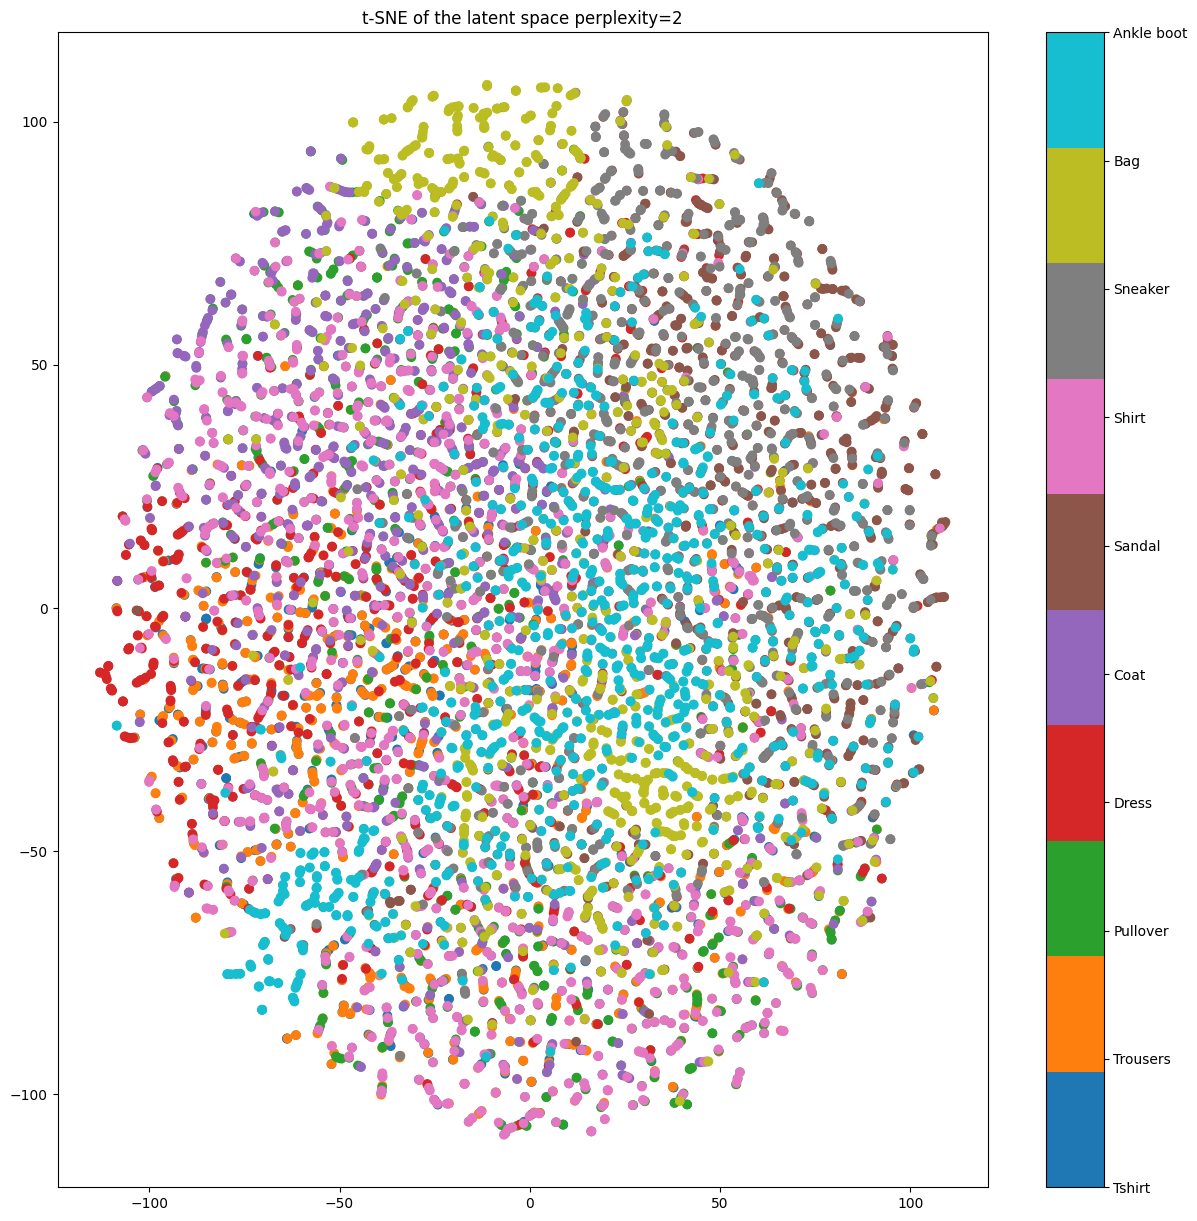

In [32]:
# Visualize the data
plt.figure(figsize=(15, 15))
plt.title("t-SNE of the latent space perplexity=2")
scatter = plt.scatter(X_2p_tsne[:, 0], X_2p_tsne[:, 1], c=y, cmap='tab10')

# Create a custom colorbar with specified labels
custom_cmap = ListedColormap(['tab10(%d)' % i for i in range(len(class_labels))])
cbar = plt.colorbar(scatter, ticks=range(len(class_labels)))
cbar.set_ticklabels(class_labels)
plt.show()

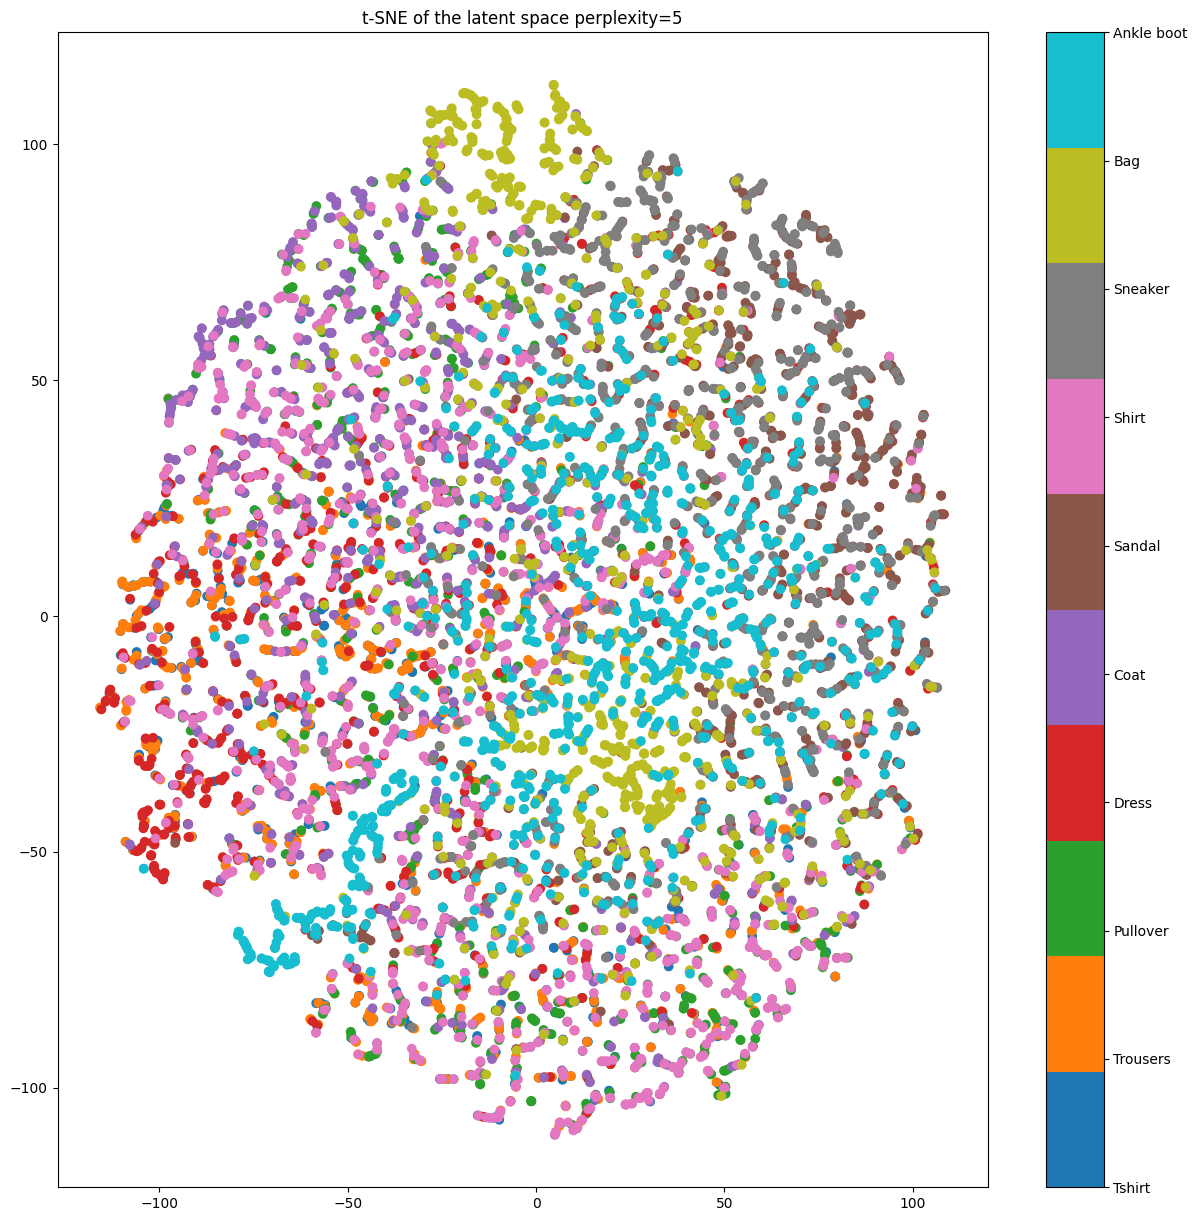

In [33]:
# Visualize the data
plt.figure(figsize=(15, 15))
plt.title("t-SNE of the latent space perplexity=5")
scatter = plt.scatter(X_5p_tsne[:, 0], X_5p_tsne[:, 1], c=y, cmap='tab10')

# Create a custom colorbar with specified labels
custom_cmap = ListedColormap(['tab10(%d)' % i for i in range(len(class_labels))])
cbar = plt.colorbar(scatter, ticks=range(len(class_labels)))
cbar.set_ticklabels(class_labels)
plt.show()

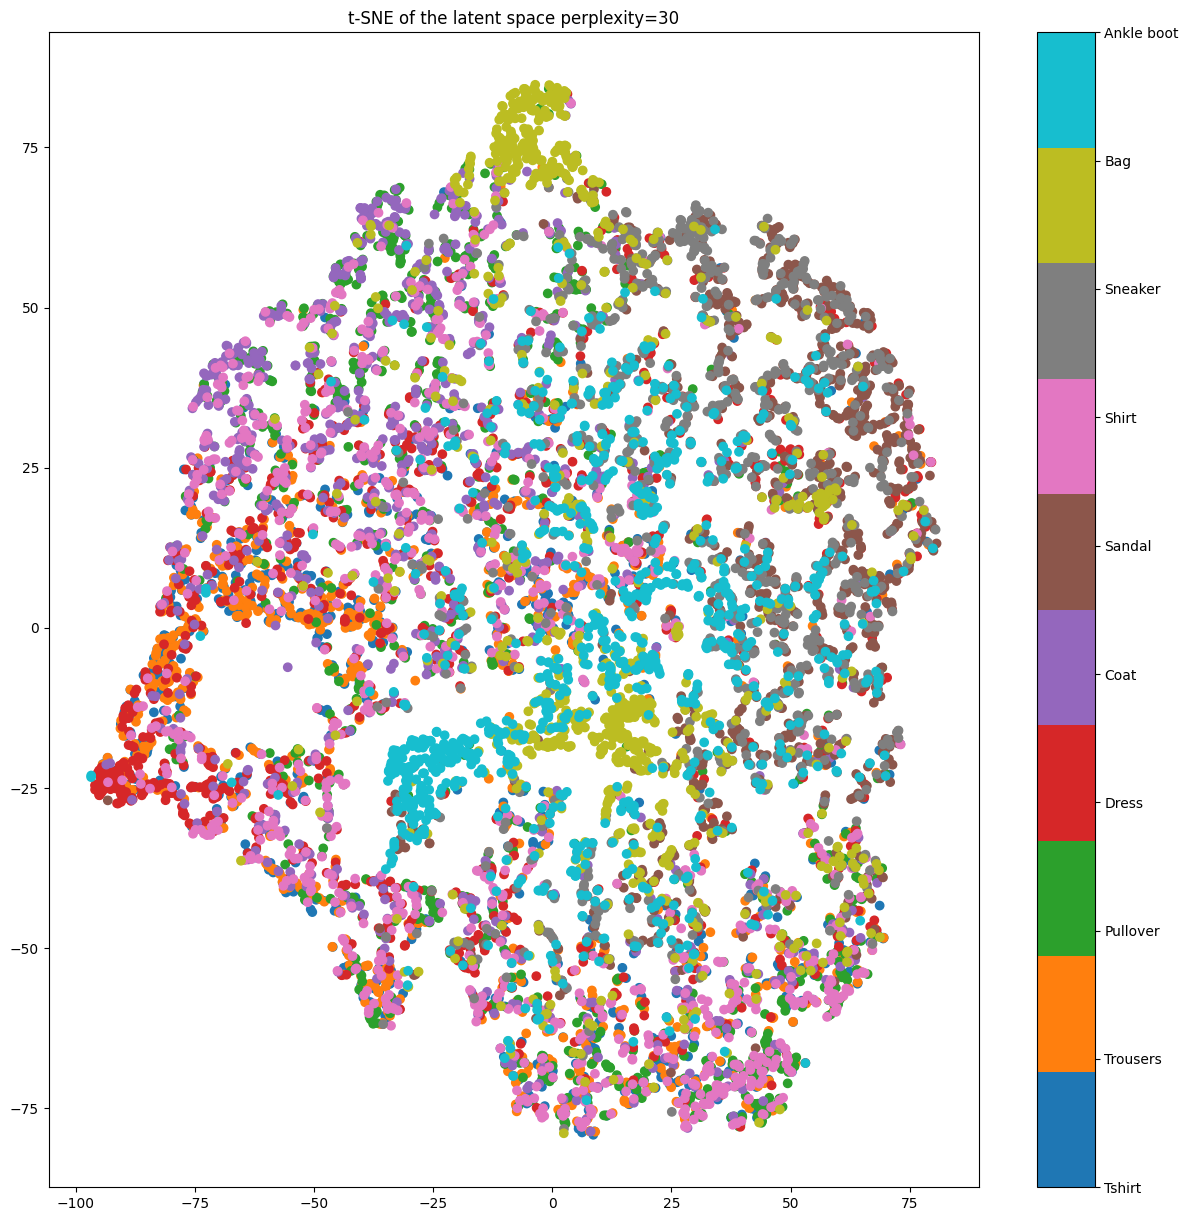

In [34]:
# Visualize the data
plt.figure(figsize=(15, 15))
plt.title("t-SNE of the latent space perplexity=30")
scatter = plt.scatter(X_30p_tsne[:, 0], X_30p_tsne[:, 1], c=y, cmap='tab10')

# Create a custom colorbar with specified labels
custom_cmap = ListedColormap(['tab10(%d)' % i for i in range(len(class_labels))])
cbar = plt.colorbar(scatter, ticks=range(len(class_labels)))
cbar.set_ticklabels(class_labels)
plt.show()

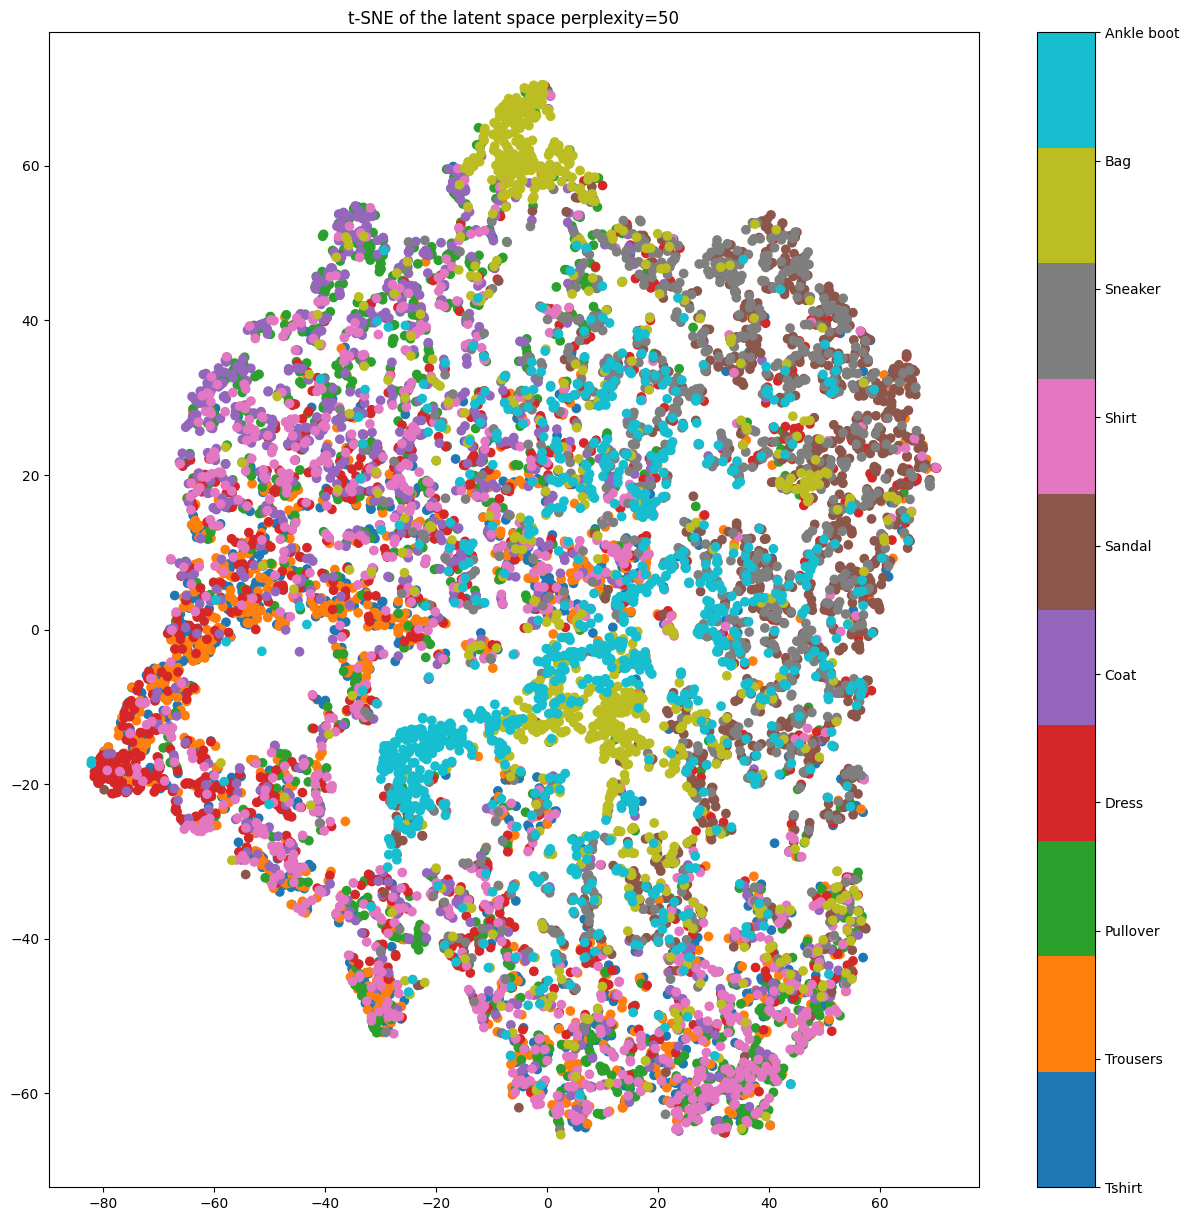

In [35]:
# Visualize the data
plt.figure(figsize=(15, 15))
plt.title("t-SNE of the latent space perplexity=50")
scatter = plt.scatter(X_50p_tsne[:, 0], X_50p_tsne[:, 1], c=y, cmap='tab10')

# Create a custom colorbar with specified labels
custom_cmap = ListedColormap(['tab10(%d)' % i for i in range(len(class_labels))])
cbar = plt.colorbar(scatter, ticks=range(len(class_labels)))
cbar.set_ticklabels(class_labels)
plt.show()

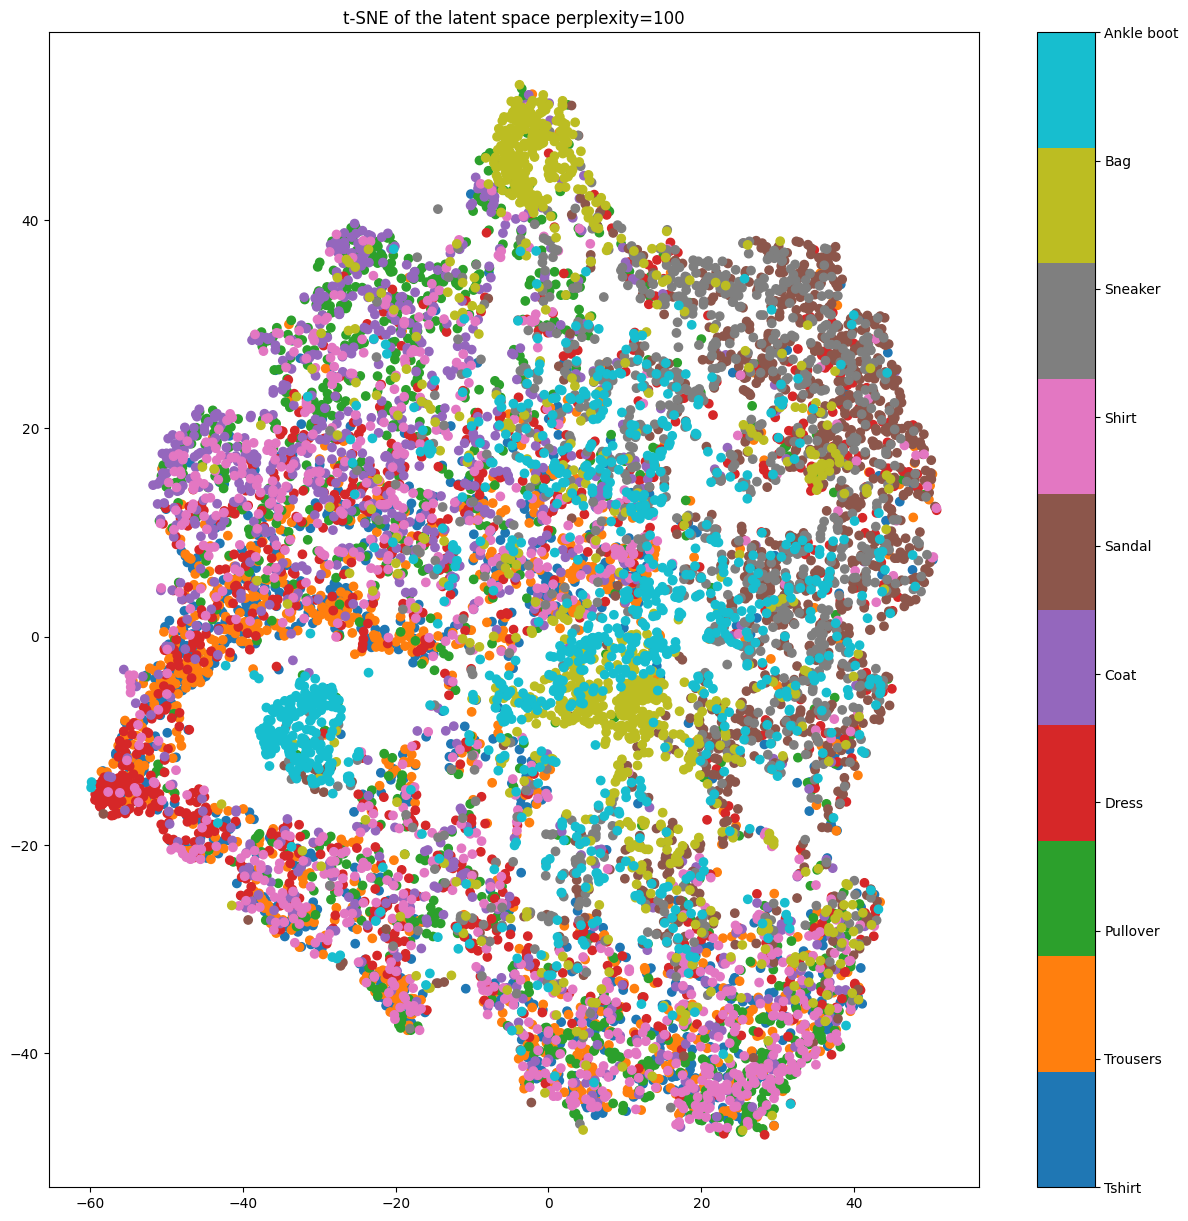

In [36]:
# Visualize the data
plt.figure(figsize=(15, 15))
plt.title("t-SNE of the latent space perplexity=100")
scatter = plt.scatter(X_100p_tsne[:, 0], X_100p_tsne[:, 1], c=y, cmap='tab10')

# Create a custom colorbar with specified labels
custom_cmap = ListedColormap(['tab10(%d)' % i for i in range(len(class_labels))])
cbar = plt.colorbar(scatter, ticks=range(len(class_labels)))
cbar.set_ticklabels(class_labels)
plt.show()

# Conclusions

After analyzing the t-SNE results with varying perplexity values, it becomes evident that higher perplexity settings lead to more clustered visualizations. This aligns with the expectation that higher perplexity allows the algorithm to prioritize the preservation of global structures within the data, resulting in well-defined clusters.

## Overlapping of data from different classes

However, a noteworthy observation is the overlap of data points from different classes in some cases. The latent space, derived from an encoder fed with images from different classes, exhibits instances where the boundaries between classes are not distinctly delineated. This phenomenon raises the question of why such overlap occurs.

The possible explanations for overlapping data are the following:

1. **Complex Relationships:** the latent space may capture intricate relationships and similarities between different classes, leading to overlap. This complexity could arise from shared features or nuanced distinctions that are challenging to separate.

2. **Inherent Ambiguity:** certain classes may inherently share characteristics that make them difficult to segregate in the latent space. Variations within classes and similarities between them can contribute to overlapping clusters.

3. **Limited Dimensionality:** despite the power of t-SNE, the reduction to a lower-dimensional space may not fully capture the complexity of high-dimensional data. Some overlap may be a consequence of the inherent limitations of projecting high-dimensional information into a 2D or 3D space.

### Implications and further exploration

Understanding and addressing the overlap of data from different classes in the latent space are crucial for improving the performance of the encoder. Further investigation, experimentation, and potentially refining the training process may help mitigate overlap and enhance the discriminative capabilities of the latent representations.

In summary, while higher perplexity settings contribute to more distinct clusters, the presence of overlap highlights the intricacies and challenges involved in capturing class-specific information in the latent space.

---


---

# PCA Process

In this exploration, we will delve into the process of Principal Component Analysis (PCA), a powerful technique for dimensionality reduction. Unlike t-SNE, PCA operates through a linear approach, aiming to identify the principal components of the data that capture the maximum variance. PCA falls under the umbrella of unsupervised machine learning, providing insights into hidden patterns and relationships within the data without relying on labeled information.

## Overview of PCA

PCA's primary objective is to transform the original high-dimensional data into a new coordinate system defined by its principal components. These components are orthogonal vectors that represent the directions of maximum variance in the data. By projecting the data onto these principal components, PCA effectively reduces the dimensionality while retaining the most crucial information. \
As opposed to t-SNE's non-linear approach, PCA's linearity allows for a deterministic transformation. This means that given the same input data, PCA will consistently yield the same output, making it reliable for stable and repeatable results. However, it's important to note that the linear nature of PCA may lead to a loss of local relationships, such as clusters, in the data after projection.

## Practical applications

PCA finds applications in various fields, including image processing, feature extraction, and noise reduction. By providing a concise representation of the data in a reduced dimensional space, PCA facilitates enhanced visualization, interpretation, and often aids in subsequent machine learning tasks.

In the following sections, we will explore the nuances of PCA, understand its strengths and limitations, and uncover how it contributes to revealing the underlying structures within complex datasets.


In [166]:
X = np.concatenate((z_zero, z_one, z_two, z_three, z_four, z_five, z_six, z_seven, z_eight, z_nine), axis=0)
print(X.shape)

# Create the labels
y = np.concatenate((np.zeros(z_zero.shape[0]), np.ones(z_one.shape[0]), np.ones(z_two.shape[0])*2, np.ones(z_three.shape[0])*3, np.ones(z_four.shape[0])*4, np.ones(z_five.shape[0])*5, np.ones(z_six.shape[0])*6, np.ones(z_seven.shape[0])*7, np.ones(z_eight.shape[0])*8, np.ones(z_nine.shape[0])*9), axis=0)
print(y.shape)
#Match labels index with label name
y_string = [label_dict[i] for i in y]


pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X)

print(pca_2d.shape)

(60000, 4)
(60000,)
(60000, 2)


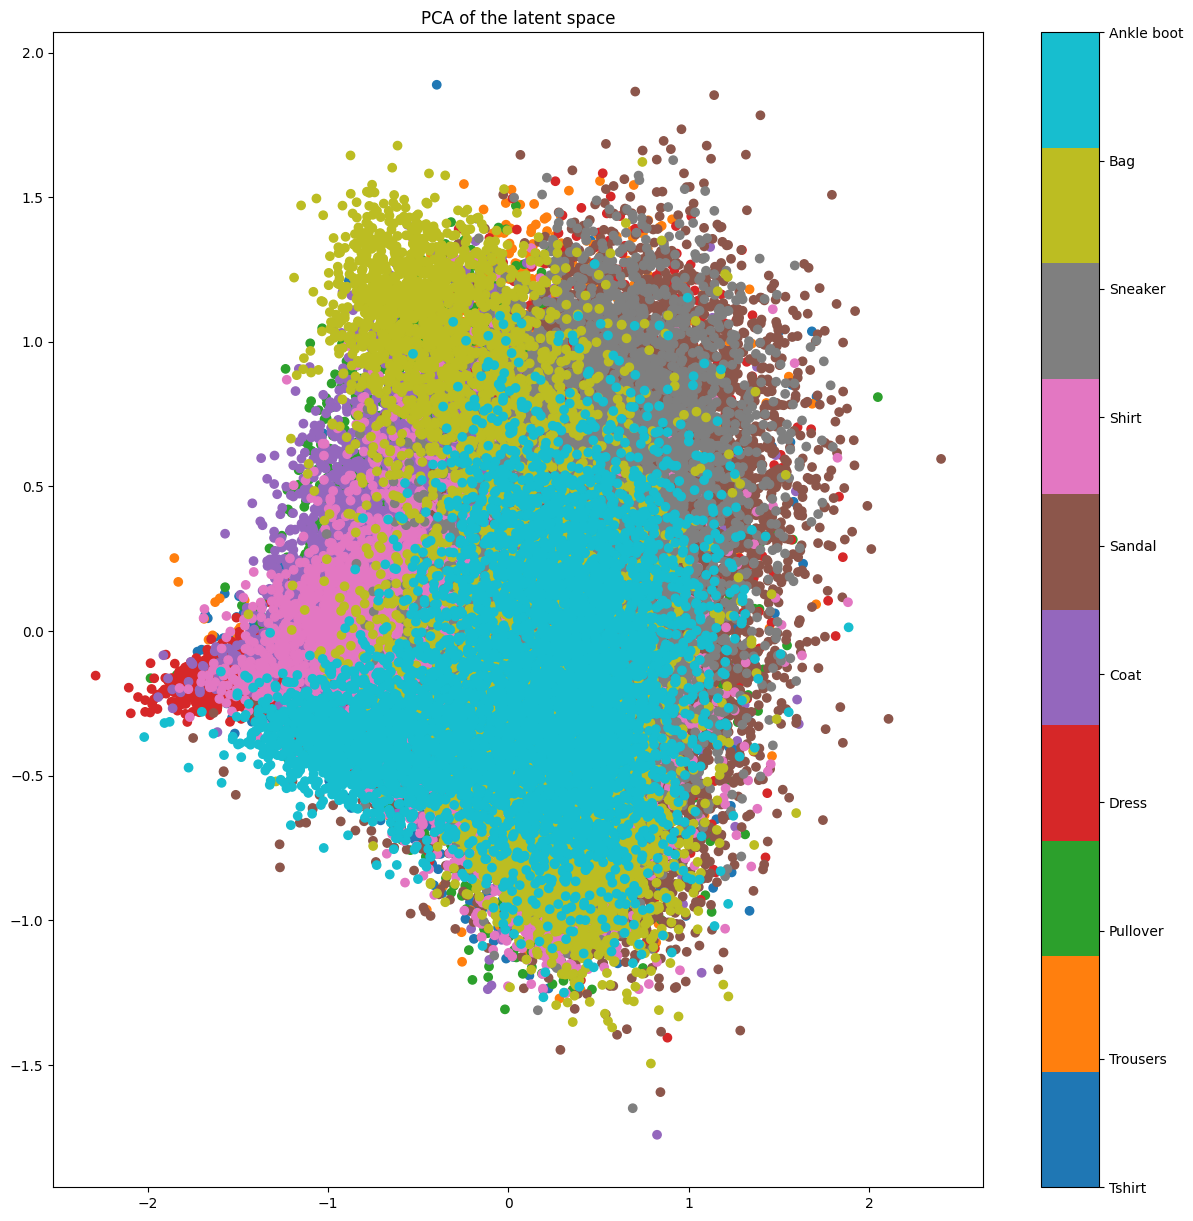

In [169]:
# Visualize the data
plt.figure(figsize=(15, 15))
plt.title("PCA of the latent space")
scatter = plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=y, cmap='tab10')

# Create a custom colorbar with specified labels
custom_cmap = ListedColormap(['tab10(%d)' % i for i in range(len(class_labels))])
cbar = plt.colorbar(scatter, ticks=range(len(class_labels)))
cbar.set_ticklabels(class_labels)
plt.show()

# Conclusions

Upon examining the results of Principal Component Analysis (PCA), it becomes evident that the technique excels in capturing the inherent structures of the data. The visualizations indicate that data from the same classes tend to cluster together in the same region of the plane, aligning with the expectation that PCA identifies principal components that capture the maximum variance.

## Clustered representation of same classes

The strength of PCA lies in its ability to provide a compact and organized representation of the data, with distinct clusters formed by samples from the same classes. This inherent grouping showcases the efficacy of PCA in highlighting similarities and shared characteristics among data points. \
Nonetheless, it's notable that in certain instances clusters exhibit overlap. Despite the overall cohesion within class-specific regions, the presence of overlap raises questions about the factors contributing to these intersections.

Potential factors for overlapping clusters are the following:

1. **Inherent Variability:** overlapping clusters may result from inherent variability within classes, making it challenging to fully separate them in a lower-dimensional space.

2. **Projection Limitations:** while PCA captures global structures well, the linear projection may encounter difficulties in precisely segregating closely related classes or capturing finer details in the data.

3. **Noise or Outliers:** the presence of noise or outliers in the data could contribute to overlapping clusters, especially if these anomalies exhibit characteristics common to multiple classes.

## Implications and Further Exploration

Understanding the characteristics of overlapping clusters is essential for refining the performance of PCA. Further exploration, experimentation, and potential adjustments to the data preprocessing or PCA parameters may aid in mitigating overlap and improving the fidelity of class representations.

In summary, PCA successfully forms cohesive clusters for samples from the same classes, but the observed overlap emphasizes the need for a nuanced interpretation of results and continued refinement for optimal representation of complex datasets.

---



---

# Exploring overlapping classes: image generation comparison

In this section, we embark on a detailed exploration of classes that exhibit overlapping clusters in the PCA and t-SNE visualizations. Our focus is to delve into the generated images from these overlapping classes, seeking to identify common features or patterns that could provide insights into the observed overlap in the latent space. \
The primary objective is to understand whether the overlapping clusters share distinct visual characteristics in the generated images: by comparing the features of images from classes that overlap in the reduced-dimensional space, we aim to uncover potential similarities or recurrent elements that might contribute to the observed overlap.

## Methodology

We will generate images from the overlapping classes and conduct a side-by-side comparison, meticulously analyzing the visual content. This comparative study aims to elucidate whether shared features in the generated images align with the patterns observed in the latent space, shedding light on the factors influencing the clustering behavior.

## Significance

The investigation into the features of generated images from overlapping classes holds significant implications for understanding the representation and discriminative capabilities of the latent space. Discovering commonalities or distinctions in the visual content may contribute valuable insights towards refining the image generation process and enhancing the interpretability of the latent representations.

As we delve into this comparative analysis, we anticipate uncovering nuanced relationships between image features and latent space representations, further enriching our understanding of the complex interplay between generated images and the clustering behavior observed in dimensionality-reduced spaces.


# DRESS VS COAT

0it [00:00, ?it/s]

Latent shape:  torch.Size([12, 4])


0it [00:00, ?it/s]


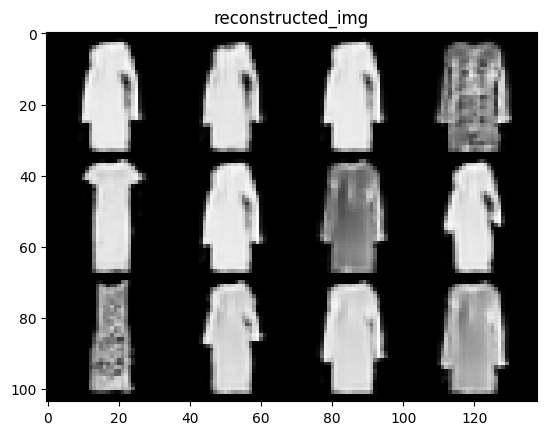

In [12]:
#DRESS
pip.inference_fromdt(three_dl)

0it [00:00, ?it/s]

Latent shape:  torch.Size([12, 4])


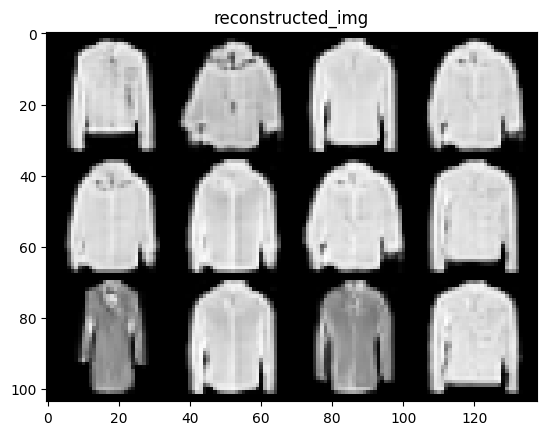

In [172]:
#COAT
pip.inference_fromdt(four_dl)

# SNEAKER7 AND SANDAL 5


0it [00:00, ?it/s]

Latent shape:  torch.Size([12, 4])


0it [00:00, ?it/s]


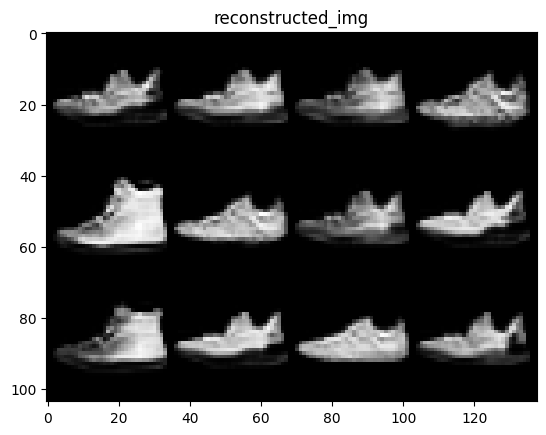

In [180]:
pip.inference_fromdt(seven_dl)

0it [00:00, ?it/s]

Latent shape:  torch.Size([12, 4])


0it [00:01, ?it/s]


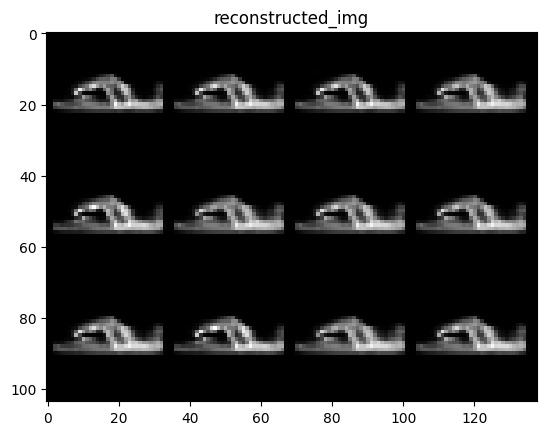

In [179]:
pip.inference_fromdt(five_dl)